## 0. 문제 설정

#### (1) continuum 을 구할 때수소, 헬륨, 금속의 무게비를 70, 28, 2%으로, 금속의 질량을 20amu로 가정한다.  갯수비는 1, 28/4/70=0.1, 2/20/70=1/700 이 된다.  

#### (3)  Bohm-Vitense Table 12.3에 표기된 값을 따라 수소(log10(12)), 헬륨 (log10(11)),  탄소(log10(8.5))을 사용한다.

#### (4) Gray appendixD 에 따라 탄소의 이온화 에너지와 분배함수는 아래와 같이 사용한다.
#### ionization potential: I1 = 11.260, I2 = 24.383, I3 = 47.888
#### partition functions, log u(T) : 

|theta|0.2|0.4|0.6|0.8|1.0|1.2|1.4|1.6|1.8|2.0|log g0|
|---|---|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|C  |1.163|1.037|0.994|0.975|0.964|0.958|0.954|0.951|0.950|0.948|0.954|
|C+ |0.853|0.782|0.775|0.774|0.773|0.772|0.771|0.770|0.769|0.767|0.778|
|C++|0.143|0.010|0.000|0.000|0.000|0.000|0.000|0.000|0.000|0.000|0.000|


## 1. 숙제 3 코드를 활용하여 연속흡수계수와 스펙트럼 계산하기

In [43]:
#import necessary modules
import numpy as np
from scipy.interpolate import interp1d
from scipy import integrate

import matplotlib.pyplot as plt
import scipy as scipy
from astropy.modeling.models import Voigt1D

### (1) calculate geometrical depth

In [44]:
e = 4.8024e-10
ev=4.8e-10
h=6.626e-27
k=1.38e-16
c=3.e10
me=9.105e-28
mh=1.66e-24

teff=5500.
grav=1.e4

rhox,temp,pg,ne=np.loadtxt('Kurucz.dat',unpack=True,skiprows=5,usecols=[0,1,2,3])


theta=5040./temp
pe=ne*k*temp

#degree of ionization of H, C
theta_t= [0.2,  0.4,  0.6,  0.8,  1.0,  1.2,  1.4,  1.6,  1.8,  2.0  ]
#Hydrogen
h0u_t=   [0.368, 0.303, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301, 0.301]
#Carbon
c0u_t=   [1.163, 1.037, 0.994, 0.975, 0.964, 0.958, 0.954, 0.951, 0.950, 0.948]
cpu_t=   [0.853, 0.782, 0.775, 0.774, 0.773, 0.772, 0.771, 0.770, 0.769, 0.767]
cppu_t=  [0.143, 0.010, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000, 0.000]


h0uint = interp1d(theta_t, h0u_t, kind = 'slinear')
h0u = h0uint(theta)
h0u=np.power(10, h0u)

c0uint = interp1d(theta_t, c0u_t, kind = 'slinear')
c0u = c0uint(theta)
c0u=np.power(10, c0u)

cpuint = interp1d(theta_t, cpu_t, kind = 'slinear')
cpu = cpuint(theta)
cpu=np.power(10, cpu)

cppuint = interp1d(theta_t, cppu_t, kind = 'slinear')
cppu = cpuint(theta)
cppu=np.power(10, cppu)


#saha equation - hydrogen
hph0=-np.log10(h0u)+np.log10(2)+2.5*np.log10(temp) -13.6*theta-np.log10(pe)-0.48
h0hm=+np.log10(h0u)+np.log10(2)+2.5*np.log10(temp)-0.754*theta-np.log10(pe)-0.48

hph0=np.power(10,hph0)
h0hm=np.power(10,h0hm)

#saha equation - carbon
cpc0 = np.log10(cpu)-np.log10(c0u) + np.log10(2)+2.5*np.log10(temp) -11.260*theta-np.log10(pe)-0.48
cppcp = np.log10(cppu)-np.log10(cpu) + np.log10(2)+2.5*np.log10(temp) -24.388*theta-np.log10(pe)-0.48

cpc0 = np.power(10,cpc0)
cppcp = np.power(10, cppcp)

# calculate density ---- actually little ionization
nh=(pg/k/temp-ne)/(1.+0.1+2./70./20.)
rho=mh*nh*(1.+4*0.1+20.*(2./20./70.))

# count #
nh0=nh/(1./h0hm+1.+hph0)
nhm=1./h0hm*nh0
nhp=hph0*nh0

nc0 = nh0 * 10**(-3.5)
ncp = cpc0 * nc0
ncpp = cppcp * ncp

# geometrical depth
z=np.zeros(64)
for i in range(1,64):
    z[i]=z[i-1]+2.*(rhox[i]-rhox[i-1])/(rho[i-1]+rho[i])/1.e5   # in kilometers


In [45]:
#number of carbon in 3p 3d state
nc3_1 = nc0 * 10**(-1.31)/10**(0.954) * 10**(-8.65 * theta)
nc3_2 = nc0 * 10**(-1.67)/10**(0.954) * 10**(-8.65 * theta)
nc3_3 = nc0 * 10**(-1.)/10**(0.954) * 10**(-8.64 * theta)
c_nums = [nc3_1, nc3_2, nc3_3]

In [46]:
#carbon energy
E_i = [8.65, 8.65, 8.64] # [eV]
E_j = [4.1357e-15*3e8/(6013.17e-10) +E_i[0], 4.1357e-15*3e8/(6013.21e-10)+E_i[1],4.1357e-15*3e8/(6014.83e-10)+E_i[2]]
E_ion = 11.260

### (2) continuous absorption coefficient
#### (2)-1 Hydrogen bound-free absorption coefficient

In [47]:
quan_num=np.arange(5)+1

ex_ener=13.6*(1.-1./np.square(quan_num))

freq_ion=13.6/np.square(quan_num)*1.6e-12/h
abs_cross=64.*np.pi**4*me*ev**10/3./np.sqrt(3)/c/h**6/quan_num**5

def k_H_bf(depth_index, lam):
    freq =  [c/x/1.e-8 for x in lam]
    
    freq1 = c/931/1.e-8
    freq2 = c/3654/1.e-8
    freq3 = c/8221/1.e-8
    freq4 = c/14616/1.e-8
    freq5 = c/23275/1.e-8
    
    abs_coef_0 = [abs_cross[0]*2.*1.*np.exp(-0.)/h0u[depth_index]/x**3 *nh0[depth_index] if freq1 < x else 0 for x in freq]

    abs_coef_1 = [abs_cross[1]*2.*4.*np.exp(-ex_ener[1]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index]
                  if freq2 < x else 0 for x in freq]

    abs_coef_2 = [abs_cross[2]*2.*9.*np.exp(-ex_ener[2]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index] 
                if freq3 < x else 0 for x in freq]
    
    abs_coef_3 = [abs_cross[3]*2.*16.*np.exp(-ex_ener[3]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index]
                if freq4 < x else 0 for x in freq]
    
    abs_coef_4 = [abs_cross[4]*2.*25.*np.exp(-ex_ener[4]*1.16e4/temp[depth_index])/h0u[depth_index]/x**3 *nh0[depth_index]
                 if freq5 < x else 0 for x in freq]
   
    abs_coef_h_bf = [x+y+z+w+i for x,y,z,w,i in zip(abs_coef_0, abs_coef_1, abs_coef_2, abs_coef_3, abs_coef_4)]
    
    return abs_coef_h_bf
    
# abs_coef_h_bf_log = np.log10(abs_coef_h_bf)

In [48]:
wave = np.arange(1, 16000, 1)

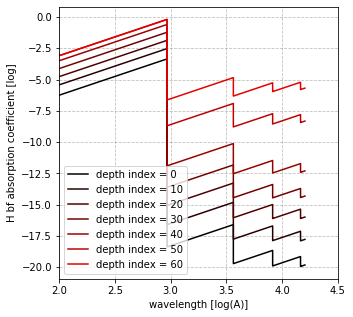

In [49]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim([2,4.5])
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('H bf absorption coefficient [log]')
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')

for i in np.arange(0,63, 10):
    ax.plot(np.log10(wave), np.log10(k_H_bf(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')

ax.legend()

#### (2)-2 Hydrogen free-free absorption coefficient

In [50]:
# H f-f absorption coefficient

def k_H_ff(depth_index, lam):
    abs_coef_h_ff=1.0449e-26*0.43429*np.power(10,-13.6*theta[depth_index])/2./theta[depth_index]/13.6*(lam/1.e8)**3*1.e24*nh0[depth_index]
    return abs_coef_h_ff

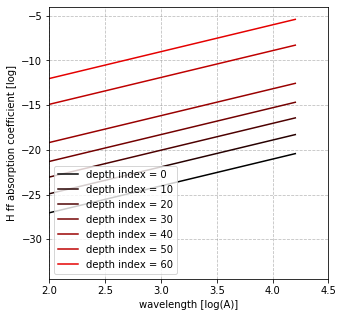

In [51]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_xlim([2,4.5])
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('H ff absorption coefficient [log]')

ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
for i in np.arange(0,63, 10):
    ax.plot(np.log10(wave), np.log10(k_H_ff(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')
ax.legend()

#### (2)-3 H- bound-free absorption coefficient

In [52]:
# H- b-f absorption coefficient
acoef0=1.99654
acoef1=-1.18267e-5
acoef2=2.64243e-6
acoef3=-4.40524e-10
acoef4=3.23992e-14
acoef5=-1.39568e-18
acoef6=2.78701e-23

def k_Hm_bf(depth_index, lam):
    wav=lam/1.e8
    freq =  [c/x/1.e-8 for x in lam]
    abs_coef_hm_bf=(acoef0+acoef1*wav*1.e8 +acoef2*wav**2*1.e16+acoef3*wav**3*1.e24 \
                        +acoef4*wav**4*1.e32+acoef5*wav**5*1.e40+acoef6*wav**6*1.e48)*1.e-18 \
                        *4.158e-10*pe[depth_index]*theta[depth_index]**2.5*np.power(10,0.754*theta[depth_index])\
                        *nh0[depth_index]*(1-np.exp(-h*freq[depth_index]/k/temp[depth_index]))\
    
    return abs_coef_hm_bf

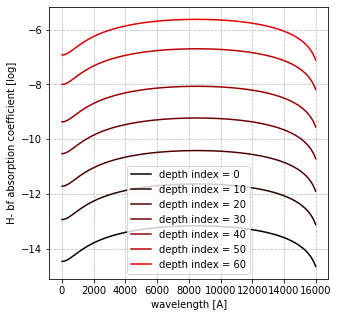

In [53]:
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('wavelength [A]')
ax.set_ylabel('H- bf absorption coefficient [log]')

for i in np.arange(0,63, 10):
    ax.plot(wave, np.log10(k_Hm_bf(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')
ax.legend()

#### (2)-4 H- free-free absorption coefficient

In [12]:
def k_Hm_ff(depth_index, lam):
    
#     wav = lam /1.e8
    wav = lam
    f0=-2.2763-1.685*np.log10(wav)+0.76661*(np.log10(wav))**2-0.053346*(np.log10(wav))**3
    f1=15.2827-9.2846*np.log10(wav)+1.99381*(np.log10(wav))**2-0.142631*(np.log10(wav))**3
    f2=-197.789+190.266*np.log10(wav)-67.9775*(np.log10(wav))**2+10.6913*(np.log10(wav))**3-0.62515*(np.log10(wav))**4
    
    abs_coef_hm_ff=1.e-26*pe[depth_index]*np.power(10,f0+f1*np.log10(theta[depth_index])+f2*(np.log10(theta[depth_index]))**2)*nh0[depth_index]

    return abs_coef_hm_ff

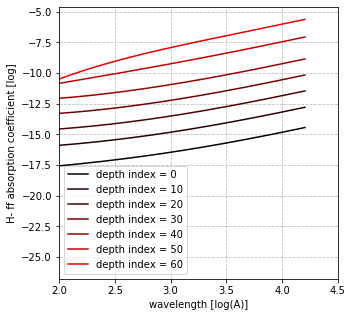

In [13]:
fig, ax = plt.subplots(figsize=(5,5))
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('H- ff absorption coefficient [log]')
ax.set_xlim(2,4.5)
for i in np.arange(0,63, 10):
    ax.plot(np.log10(wave), np.log10(k_Hm_ff(i, wave)), color = [0.015*i,0,0], label = f'depth index = {i}')
ax.legend()

## 2. 선 흡수계수 계산
#### (1) Lorentz profile: natural broadening, pressure broadening

In [14]:
# natural, stark, van: 0/1
def lorentz_profile(depth_index, lam, lam_0, natural, stark, van, c_num):
    
#     lam0 = lam_0*10**(-8)
#     wav = lam * 10**(-8)
     
    freq = c/lam/1.e-8
    freq0 = c/lam_0/1.e-8
    
    natural_gam = 2 * e**2 * (2*np.pi * freq0)**2 / 3 /me / c**3
    stark_gam = 10e-8 * (13.6 * 1**2 / (E_ion - E_j[c_num]))**(2.5) *ne[depth_index]

    v = (8/np.pi*(1/6/mh + 1/mh)*k*temp[depth_index])**(1/2)
    van_gam = 17 * (1.61 * 10**(-33) * (13.6*1)**2 * ((E_ion - E_j[c_num])**(-2) - (E_ion - E_i[c_num]**(-2))))**(0.4) * v**(0.6) *nh[depth_index] 

    gamma = natural*natural_gam +  stark*stark_gam + van*van_gam
    
    const = e**2 / me /c
    
    profile = const * gamma/np.pi/4/((freq - freq0)**2 + (gamma/4/np.pi)**2) * c_nums[c_num][depth_index]
    
    return profile

#### natural broadening만 고려했을 때 아래와 같이 wing이 발달한 lorentz profile 꼴이 나타난다. 

#### 또한 깊어질수록 수소가 이온화되는 정도가 커져 전자 밀도가 커지므로 흡수계수가 더욱 커지는 것을 관찰할 수 있다.

C:\Anaconda\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


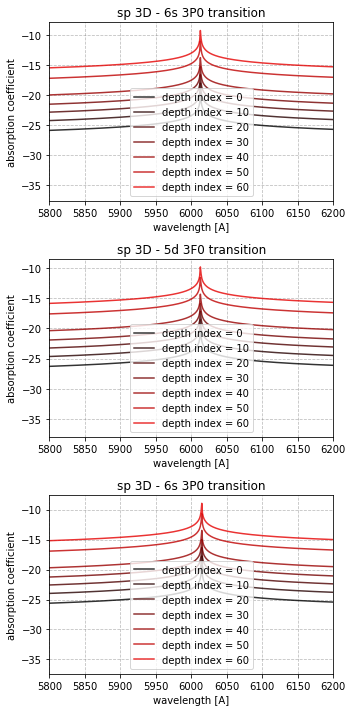

In [15]:
wave = np.arange(1,16000)

fig, axs = plt.subplots(3,figsize=(5,10))

for i in range(3):
    axs[i].set_xlim([5800,6200])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
    axs[i].set_xlabel('wavelength [A]')
    axs[i].set_ylabel('absorption coefficient')
    
axs[0].set_title('sp 3D - 6s 3P0 transition')
axs[1].set_title('sp 3D - 5d 3F0 transition')
axs[2].set_title('sp 3D - 6s 3P0 transition')

for i in np.arange(0,63, 10):
    axs[0].plot(wave,np.log10(lorentz_profile(i, wave, 6013.17, 1,0,0, 0)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[1].plot(wave, np.log10(lorentz_profile(i, wave, 6013.21, 1,0,0, 1)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[2].plot(wave, np.log10(lorentz_profile(i, wave, 6014.83, 1,0,0, 2)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    
axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()

#### collisional broadening에 의한 효과도 포함하면 아래와 같이 broadening의 효과가 더욱 커진다.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:28: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
C:\Anaconda\lib\site-packages\IPython\core\events.py:88: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
C:\Anaconda\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


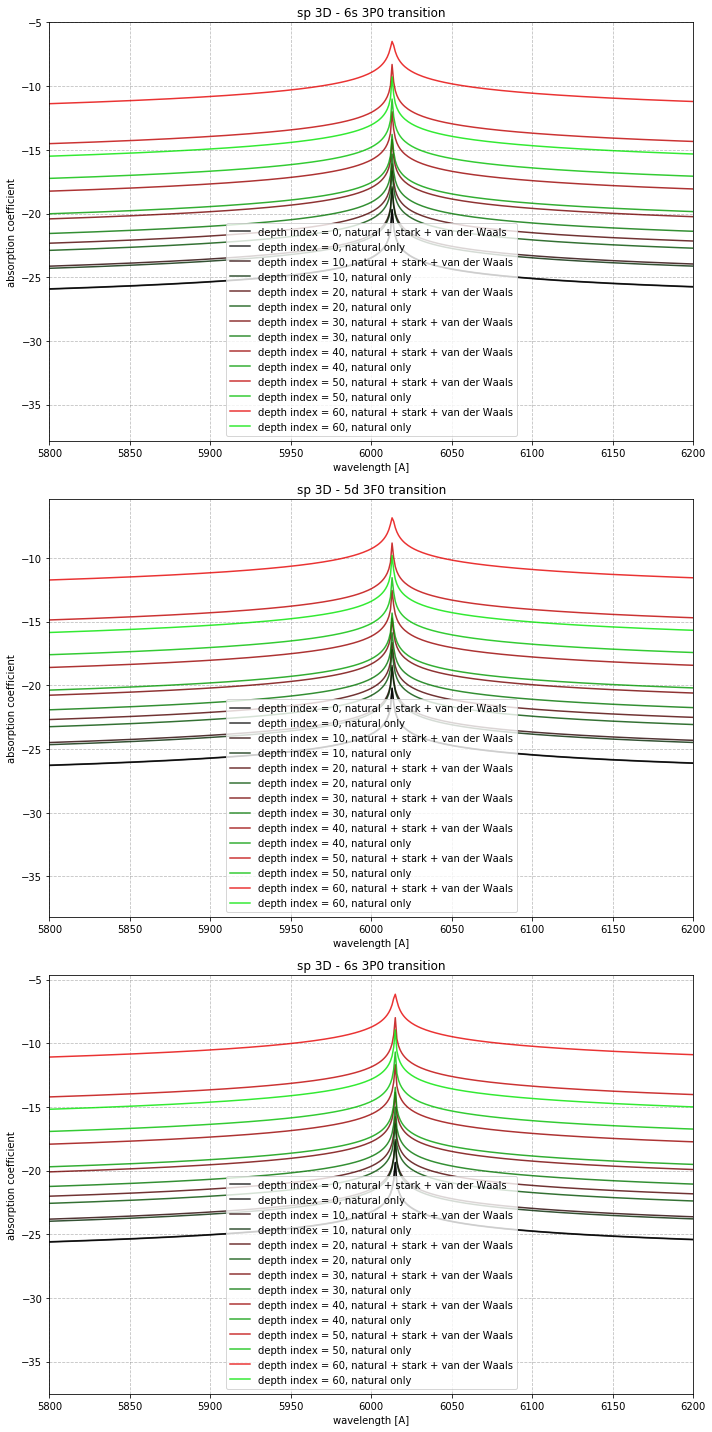

In [16]:
wave = np.arange(1,16000)

fig, axs = plt.subplots(3,figsize=(10,20))

for i in range(3):
    axs[i].set_xlim([5800,6200])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
    axs[i].set_xlabel('wavelength [A]')
    axs[i].set_ylabel('absorption coefficient')
    
axs[0].set_title('sp 3D - 6s 3P0 transition')
axs[1].set_title('sp 3D - 5d 3F0 transition')
axs[2].set_title('sp 3D - 6s 3P0 transition')

for i in np.arange(0,63, 10):
    axs[0].plot(wave,np.log10(lorentz_profile(i, wave, 6013.17, 1,1,1, 0)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}, natural + stark + van der Waals')
    axs[1].plot(wave, np.log10(lorentz_profile(i, wave, 6013.21, 1,1,1, 1)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}, natural + stark + van der Waals')
    axs[2].plot(wave, np.log10(lorentz_profile(i, wave, 6014.83, 1,1,1, 2)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}, natural + stark + van der Waals')
    
    axs[0].plot(wave,np.log10(lorentz_profile(i, wave, 6013.17, 1,0,0, 0)), color = [0,0.015*i,0],alpha = 0.8,label = f'depth index = {i}, natural only')
    axs[1].plot(wave, np.log10(lorentz_profile(i, wave, 6013.21, 1,0,0, 1)), color = [0,0.015*i,0],alpha = 0.8,label = f'depth index = {i}, natural only')
    axs[2].plot(wave, np.log10(lorentz_profile(i, wave, 6014.83, 1,0,0, 2)), color = [0,0.015*i,0],alpha = 0.8,label = f'depth index = {i}, natural only')

axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()

#### (2)  doppler broadening

In [17]:
def doppler_profile(depth_index, lam,lam_0, c_num, v_turb):
    freq = c/lam/1.e-8
    freq0 = c/lam_0/1.e-8

    vel_th = (2*k*temp[depth_index]/me)**(1/2) * freq0/c
    vel_d =  (vel_th**2 + v_turb**2)**(1/2)
    const =  e**2 / me /c
    
    profile = const * 1/np.pi**(1/2) /vel_d * np.exp(-((freq - freq0)/vel_d)**2) * c_nums[c_num][depth_index] 
    
    return profile

#### 흡수계수가 가우시안 꼴로 나타나며, 깊을수록 온도가 증가하여 broadening 효과가 크게 나타난다.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


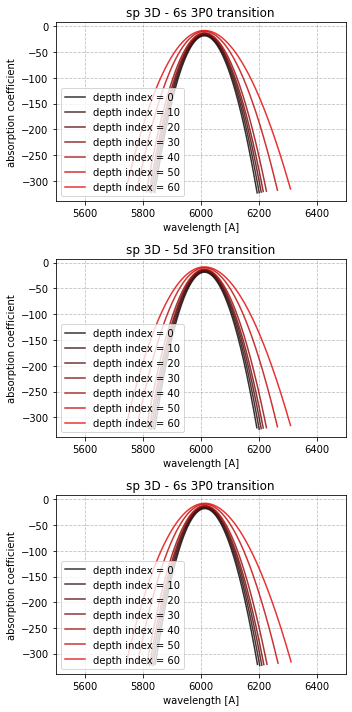

In [18]:
wave = np.arange(1,16000)

fig, axs = plt.subplots(3,figsize=(5,10))

for i in range(3):
    axs[i].set_xlim([5500,6500])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
    axs[i].set_xlabel('wavelength [A]')
    axs[i].set_ylabel('absorption coefficient')
    
axs[0].set_title('sp 3D - 6s 3P0 transition')
axs[1].set_title('sp 3D - 5d 3F0 transition')
axs[2].set_title('sp 3D - 6s 3P0 transition')

for i in np.arange(0,63, 10):
    axs[0].plot(wave,np.log10(doppler_profile(i, wave, 6013.17, 0, 150000)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[1].plot(wave, np.log10(doppler_profile(i, wave, 6013.21, 1, 150000)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')
    axs[2].plot(wave, np.log10(doppler_profile(i, wave, 6014.83, 2, 150000)), color = [0.015*i,0,0],alpha = 0.8,label = f'depth index = {i}')

axs[0].legend()
axs[1].legend()
axs[2].legend()

plt.tight_layout()


#### (3) total line coefficient : convolution of gaussian and Lorentzian

##### before convolution

#### 합성곱을 하기 전 gaussian이 lorentzian에 비해 빠르게 decaying하는 모습을 관찰할 수 있다.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]


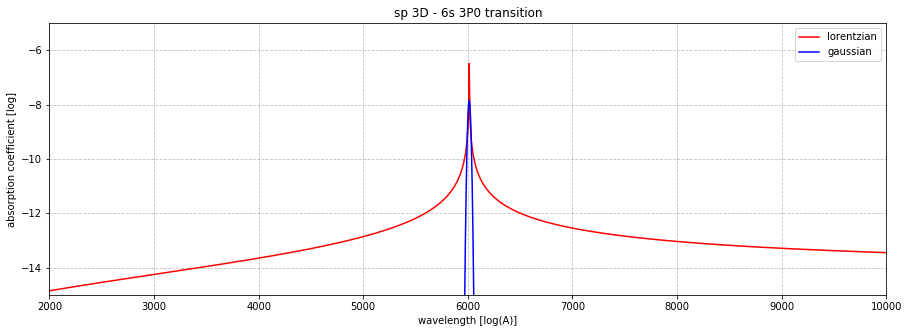

In [19]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('absorption coefficient [log]')
ax.set_xlim(2000,10000)
ax.set_ylim(-15, -5)
ax.set_title('sp 3D - 6s 3P0 transition')

k_lorentz = lorentz_profile(i, wave, 6013.17, 1,1,1, 0) 
k_doppler = doppler_profile(i, wave, 6013.17, 0, 150000)

ax.plot(wave, np.log10(k_lorentz), color = [1,0,0], label = 'lorentzian')
ax.plot(wave, np.log10(k_doppler), color = [0,0,1], label = 'gaussian')
# ax.plot(wave, k_lorentz, color = [1,0,0], label = 'lorentzian')
# ax.plot(wave, k_doppler, color = [0,0,1], label = 'gaussian')


ax.legend()

##### after convolution

In [20]:
from scipy.special import wofz

In [21]:
def voigt_profile(depth_index, lam, lam_0, natural, stark, van, c_num, v_turb, c_amount):
    freq = c/lam/1.e-8
    freq0 = c/lam_0/1.e-8
        
    #######lorentz
    natural_gam = 2 * e**2 * (2*np.pi * freq0)**2 / 3 /me / c**3
    stark_gam = 10e-8 * (13.6 * 1**2 / (E_ion - E_j[c_num]))**(2.5) *ne[depth_index]

    v = (8/np.pi*(1/6/mh + 1/mh)*k*temp[depth_index])**(1/2)
    van_gam = 17 * (1.61 * 10**(-33) * (13.6*1)**2 * ((E_ion - E_j[c_num])**(-2) - (E_ion - E_i[c_num]**(-2))))**(0.4) * v**(0.6) *nh[depth_index] 

    gamma = natural*natural_gam +  stark*stark_gam + van*van_gam
    
    const = e**2 / me /c * c_nums[c_num][depth_index] *c_amount
          
    ####doppler

    vel_th = (2*k*temp[depth_index]/me)**(1/2) * freq0/c
    vel_d =  (vel_th**2 + v_turb**2)**(1/2)
        
        
    w_z = ((freq - freq0) + 1j * gamma/2/np.pi)/(vel_d/np.sqrt(2))
    w = np.real(wofz(w_z))/(vel_d * np.sqrt(np.pi))

    return w * const/np.pi # multiply amplitude
    

#### 합성곱을 계산한 voigt profile은 gaussian보다는 느리게 decaying하고 wing부분이 발달한 것을 확인할 수 있다.

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app


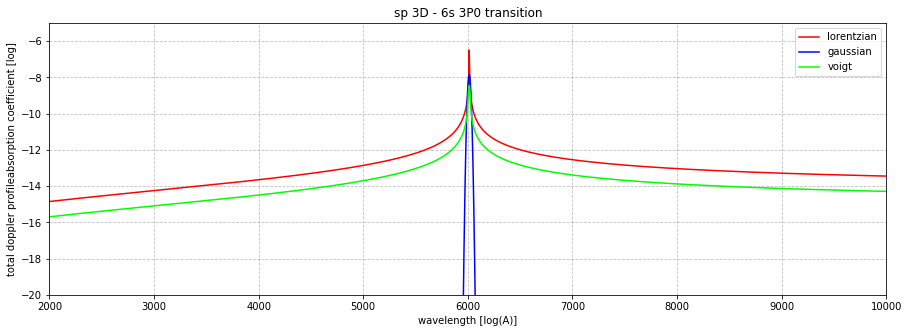

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
ax.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax.set_xlabel('wavelength [log(A)]')
ax.set_ylabel('total doppler profileabsorption coefficient [log]')
ax.set_xlim(2000,10000)
ax.set_ylim(-20, -5)
ax.set_title('sp 3D - 6s 3P0 transition')


k_lorentz = lorentz_profile(i, wave, 6013.17, 1,1,1, 0) 
k_doppler = doppler_profile(i, wave, 6013.17, 0, 150000)
k_voigt = voigt_profile(i, wave,  6013.17, 1, 1, 1,0, 150000, 1 )

ax.plot(wave, np.log10(k_lorentz), color = [1,0,0], label = 'lorentzian')
ax.plot(wave, np.log10(k_doppler), color = [0,0,1], label = 'gaussian')
ax.plot(wave, np.log10(k_voigt),  color = [0,1,0], label = 'voigt')

ax.legend()

#### (4) total absoprtion coefficient = continuous + line

#### 탄소 trasition에 의한 효과를 확인하기 위해서 함량을 늘려 확인할 결과, transition이 일어나는 파장대~6000A의 흡수계수가 증가한 것을 확인할 수 있다. 

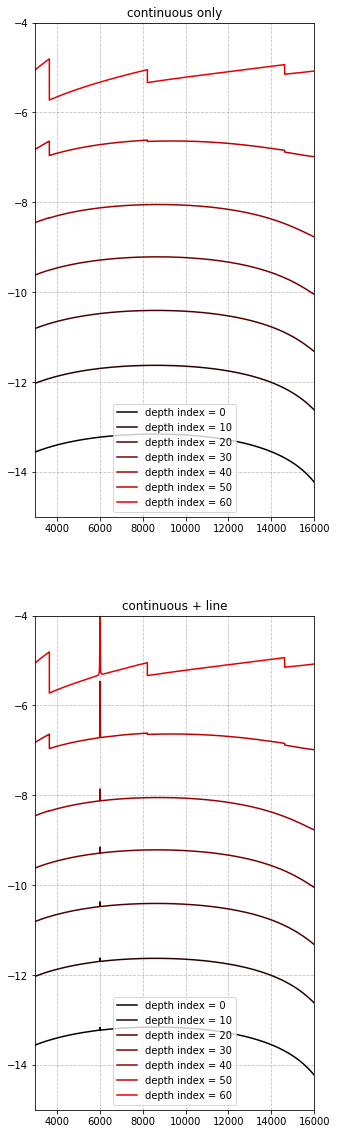

In [23]:
#total absorption coefficients
wave = np.arange(1,16000)

fig, axs = plt.subplots(2,figsize=(5,20))

for i in range(2):
    axs[i].set_xlim([3000,16000])
    axs[i].set_ylim([-15,-4])
    axs[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')

axs[0].set_title('continuous only')
axs[1].set_title('continuous + line')

for i in np.arange(0,63, 10):
    total_con = k_H_bf(i, wave)+k_H_ff(i, wave)+k_Hm_bf(i, wave)+k_Hm_ff(i, wave)
    axs[0].plot(wave, np.log10(total_con), color = [0.015*i,0,0], label = f'depth index = {i}')

    k_voigt1 = voigt_profile(i, wave,  6013.17, 1, 1, 1,0, 150000, 10000 )
    k_voigt2 = voigt_profile(i, wave,  6013.21, 1, 1, 1,1, 150000, 10000 )
    k_voigt3 = voigt_profile(i, wave, 6014.83, 1, 1, 1,2, 150000, 10000 )
    
    total_line = k_voigt1 + k_voigt2 + k_voigt3
    total_k = total_con + total_line
    
    axs[1].plot(wave, np.log10(total_k), color = [0.015*i,0,0], label = f'depth index = {i}')

axs[0].legend()
axs[1].legend()


#### 마찬가지로 깊은 곳에서(온도가 높은 곳에서) 더 깊고 높은 흡수계수가 만들어짐을 확인할 수 있다.

In [ ]:
wave = np.arange(5900,6100, 0.01)

fig, axs = plt.subplots(figsize=(5,10))

axs.set_xlim([6000,6030])
axs.grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')

axs.set_title('continuous + line, v = 1.5km/s')

for i in np.arange(0,63, 10):
    
    total_con = k_H_bf(i, wave)+k_H_ff(i, wave)+k_Hm_bf(i, wave)+k_Hm_ff(i, wave)
   
    k_voigt11 = voigt_profile(i, wave,  6013.17, 1, 1, 1,0, 150000, 10000 )
    k_voigt21 = voigt_profile(i, wave,  6013.21, 1, 1, 1,1, 150000, 10000 )
    k_voigt31 = voigt_profile(i, wave, 6014.83, 1, 1, 1,2, 150000, 10000 )
#     k_voigt21 = 0
#     k_voigt31 = 0
    
    total_line1 = k_voigt11 + k_voigt21 + k_voigt31
    total_k1 = total_con + total_line1
    
    axs.plot(wave, np.log10(total_k1), color = [0.015*i,0,0], label = f'depth index = {i}')

axs.legend()

plt.tight_layout()

In [57]:
# k_H_bf(i, wave)+k_H_ff(i, wave)+k_Hm_bf(i, wave)+k_Hm_ff(i, wave)
k_Hm_bf(i, np.arange(6000,6050,0.1))

array([1.87779008e-06, 1.87781397e-06, 1.87783787e-06, 1.87786177e-06,
       1.87788566e-06, 1.87790956e-06, 1.87793345e-06, 1.87795734e-06,
       1.87798123e-06, 1.87800513e-06, 1.87802902e-06, 1.87805291e-06,
       1.87807679e-06, 1.87810068e-06, 1.87812457e-06, 1.87814846e-06,
       1.87817234e-06, 1.87819622e-06, 1.87822011e-06, 1.87824399e-06,
       1.87826787e-06, 1.87829175e-06, 1.87831563e-06, 1.87833951e-06,
       1.87836339e-06, 1.87838727e-06, 1.87841115e-06, 1.87843502e-06,
       1.87845890e-06, 1.87848277e-06, 1.87850665e-06, 1.87853052e-06,
       1.87855439e-06, 1.87857826e-06, 1.87860213e-06, 1.87862600e-06,
       1.87864987e-06, 1.87867374e-06, 1.87869760e-06, 1.87872147e-06,
       1.87874534e-06, 1.87876920e-06, 1.87879306e-06, 1.87881693e-06,
       1.87884079e-06, 1.87886465e-06, 1.87888851e-06, 1.87891237e-06,
       1.87893623e-06, 1.87896009e-06, 1.87898394e-06, 1.87900780e-06,
       1.87903165e-06, 1.87905551e-06, 1.87907936e-06, 1.87910321e-06,
      

### 3. 선 중심과 선 외곽에서 깊이의 함수로 optical depth 구하기

In [61]:
#return optical depth as a function of depth
def cal_tau(lam, line_mask, c_amount, v_turb):
    tau_0 = [1.e-10] * len(lam)
    
    #optical depth for a given wavelength as a function of geometrical depth
    tau = []
    tau.append(tau_0)
        
    for i in range(1,64):
        
        k_voigt1_i = voigt_profile(i, wave,  6013.17, 1, 1, 1,0, v_turb, c_amount )
        k_voigt2_i = voigt_profile(i, wave,  6013.21, 1, 1, 1,1, v_turb, c_amount )
        k_voigt3_i = voigt_profile(i, wave, 6014.83, 1, 1, 1,2, v_turb, c_amount )
    
    
        line_i = k_voigt1_i + k_voigt2_i + k_voigt3_i
        con_i = k_H_bf(i, lam)+k_H_ff(i, lam)+k_Hm_bf(i, lam)+k_Hm_ff(i, lam)
        total_k_i = line_i*line_mask + con_i
        
        k_voigt1_i2 = voigt_profile(i-1, wave,  6013.17, 1, 1, 1,0, v_turb, c_amount )
        k_voigt2_i2 = voigt_profile(i-1, wave,  6013.21, 1, 1, 1,1, v_turb, c_amount )
        k_voigt3_i2 = voigt_profile(i-1, wave, 6014.83, 1, 1, 1,2, v_turb, c_amount )
    
        line_i2 = k_voigt1_i2 + k_voigt2_i2 + k_voigt3_i2
        con_i2 = k_H_bf(i-1, lam)+k_H_ff(i-1, lam)+k_Hm_bf(i-1, lam)+k_Hm_ff(i-1, lam)
        total_k_i2 = line_i2*line_mask + con_i2
        
        new_tau = tau[i-1] + (total_k_i+total_k_i2)/2 * (z[i] - z[i-1]) * 1.e5
        tau.append(new_tau)
        
    return tau

In [62]:
wave = np.arange(1, 16001)
optical_depth = cal_tau(wave, 1, 10000, 150000)
optical_depth_c = cal_tau(wave, 0, 10000, 150000)

#### 흡수계수와 마찬가지로 transition이 일어나는 파장대에서 peak이 나타남을 확인할 수 있다.

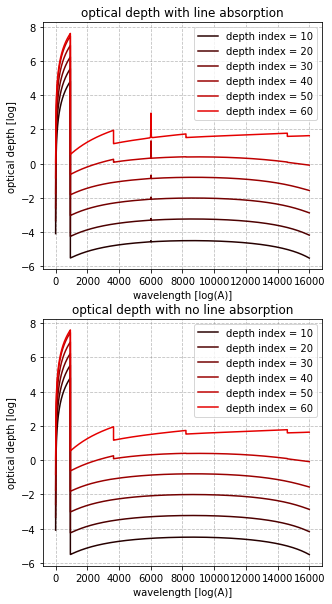

In [63]:
fig, ax = plt.subplots(2, figsize=(5,10))

for i in range(2):
    ax[i].set_xlabel('wavelength [log(A)]')
    ax[i].set_ylabel('optical depth [log]')
    ax[i].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
    
ax[0].set_title('optical depth with line absorption')
ax[1].set_title('optical depth with no line absorption')
for i in np.arange(10,63, 10):
    ax[0].plot(wave, np.log10(optical_depth[i]), color = [0.015*i,0,0], label = f'depth index = {i}')
    ax[1].plot(wave, np.log10(optical_depth_c[i]), color = [0.015*i,0,0], label = f'depth index = {i}')

ax[0].legend()
ax[1].legend()

In [64]:
def get_od(wave_num, optical_depth):

    depths = []
    for i in range(0,64):
        depth = optical_depth[i][wave_num]
        depths.append(depth)
        
    return depths

#### 선 중심(6013A)은 선 외곽에 비해서 더 큰 optical depth값을 가짐을 확인할 수 있다. 또한 그 차이는 깊이가 깊어질수록 탄소 함량이 증가하기 때문에 커진다.

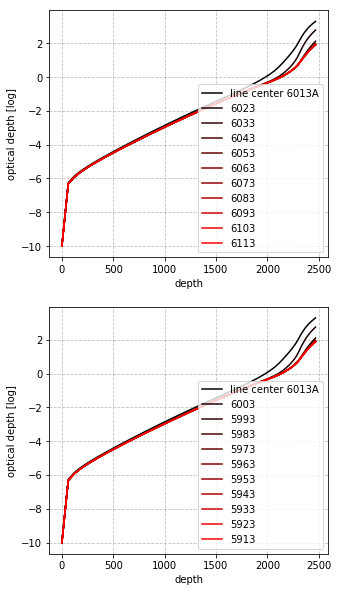

In [65]:
fig, ax = plt.subplots(2, figsize=(5,10))
# ax.set_xlim([2,4.5])
ax[0].set_xlabel('depth')
ax[0].set_ylabel('optical depth [log]')
ax[1].set_xlabel('depth')
ax[1].set_ylabel('optical depth [log]')

ax[0].plot(z, np.log10(get_od(6013, optical_depth)), color = [0.0,0,0], label = 'line center 6013A')
ax[1].plot(z, np.log10(get_od(6013, optical_depth)), color = [0.0,0,0], label = 'line center 6013A')

for i in np.arange(10, 110, 10):
    ax[0].plot(z, np.log10(get_od(6013+i, optical_depth)), color = [0.01*i,0,0], label = f'{6013+i}')
    ax[1].plot(z, np.log10(get_od(6013-i, optical_depth)), color = [0.01*i,0,0], label = f'{6013-i}')


ax[0].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax[0].legend()
ax[1].grid(True, axis='both', color='gray', alpha=0.5, linestyle='--')
ax[1].legend()

### 4. 별의 원반 중심에서 나오는 specific intensity

In [66]:
def plank_func(lam, depth_index):
    wav = lam/1.e8
#     freq = [c/x/1.e-8 for x in lam]
    freq = c/lam/1.e-8
    
    plank = 2.*h*c**2/wav**5/(np.exp(h*freq/k/temp[depth_index])-1.)
    return plank

In [67]:
intensities = []
wave = np.arange(1,15999)
for i in wave:
    planks = []
    ods = []
    for j in range(0, 64):
        planks.append(plank_func(i, j))
        ods.append(optical_depth[j][i])
    
    ods2 = [np.exp(-x) for x in ods]
    integrand = [x*y for x,y in zip(planks,ods2)]
    
    intensity = integrate.simps(integrand, ods)
    intensities.append(intensity)

In [68]:
intensities_c = []

wave = np.arange(1,15999)
for i in wave:
    planks = []
    ods = []
    for j in range(0, 64):
        planks.append(plank_func(i, j))
        ods.append(optical_depth_c[j][i])
    
    ods2 = [np.exp(-x) for x in ods]
    integrand = [x*y for x,y in zip(planks,ods2)]
    
    intensity = integrate.simps(integrand, ods)
    intensities_c.append(intensity)

#### 숙제 3에서 구한 coninuum에서 transition이 일어난 파장대의 흡수선이 추가된 스펙트럼을 관찰할 수 있다.

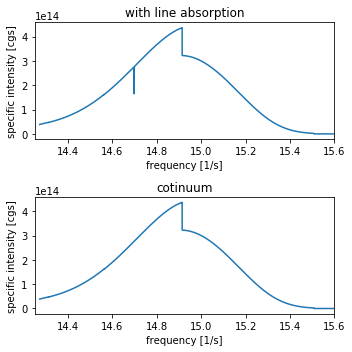

In [69]:
fig, ax = plt.subplots(2, figsize = (5,5))

ax[0].plot(np.log10(c/wave/1.e-8), intensities)
ax[1].plot(np.log10(c/wave/1.e-8), intensities_c)

for i in range(2):
    ax[i].set_xlim(14.25,15.6)
    ax[i].set_xlabel('frequency [1/s]')
    ax[i].set_ylabel('specific intensity [cgs]')
ax[0].set_title('with line absorption')
ax[1].set_title('cotinuum')

plt.tight_layout()

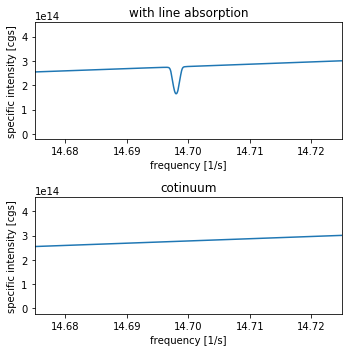

In [70]:
fig, ax = plt.subplots(2, figsize = (5,5))

ax[0].plot(np.log10(c/wave/1.e-8), intensities)
ax[1].plot(np.log10(c/wave/1.e-8), intensities_c)

for i in range(2):
    ax[i].set_xlim(14.675,14.725)
    ax[i].set_xlabel('frequency [1/s]')
    ax[i].set_ylabel('specific intensity [cgs]')
ax[0].set_title('with line absorption')
ax[1].set_title('cotinuum')

plt.tight_layout()

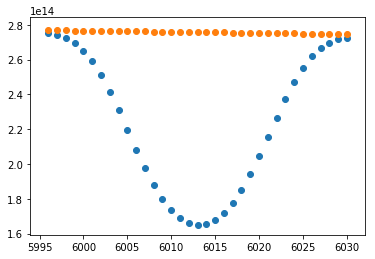

In [71]:
plt.scatter(wave[5995:6030],intensities[5995:6030])
plt.scatter(wave[5995:6030],intensities_c[5995:6030])

In [72]:
#number of c
n_c = np.logspace(0,11,12)
n_c

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08, 1.e+09, 1.e+10, 1.e+11])

## 5. 탄소 함량 변화에 따른 등가폭 변화

In [73]:
wave_c = np.arange(5995, 6030)

intensity1 = []
intensity2 = []
for nc in n_c:
    c_od = cal_tau(wave, 1, nc, 15000)
    c_od_c = cal_tau(wave,0, nc, 15000)
    
    intens = []
    intens_c = []
    
    for i in wave_c:
        planks = []
        ods = []
        
        planks_c = []
        ods_c = []
        for j in range(0, 64):
            planks.append(plank_func(i, j))
            ods.append(c_od[j][i])
            
            planks_c.append(plank_func(i,j))
            ods_c.append(c_od_c[j][i])
    
        ods2 = [np.exp(-x) for x in ods]
        integrand = [x*y for x,y in zip(planks,ods2)]
        
        ods2_c = [np.exp(-x) for x in ods_c]
        integrand_c = [x*y for x,y in zip(planks_c,ods2_c)]
        
        inte = integrate.simps(integrand, ods)
        inte_c = integrate.simps(integrand_c, ods_c)
        intens.append(inte)
        intens_c.append(inte_c)
        
    intensity1.append(intens)
    intensity2.append(intens_c)

In [74]:
LWs = []

for i in range(len(n_c)):
    F_l = intensity1[i]
    F_c = intensity2[i]
    
    R = [np.abs((x - y)/x) for x,y in zip(F_l, F_c)]
    
    integral = integrate.simps(R, wave_c)
    LWs.append(integral)

In [75]:
k_c = []
for nc in n_c:

    k_voigt1 = voigt_profile(45, wave_c,  6013.17, 1, 1, 1,0, 150000, nc )
    k_voigt2 = voigt_profile(45, wave_c,  6013.21, 1, 1, 1,1, 150000, nc )
    k_voigt3 = voigt_profile(45, wave_c, 6014.83, 1, 1, 1,2, 150000, nc )

    k_voigt = k_voigt1 + k_voigt2 + k_voigt3
    
    k_c.append(k_voigt[17])

#### 탄소 함량이 증가함에 따라 성장곡선의 로그값은 기울기가 1, 0, 1/2 순서로 증가한다.

#### linear part: 먼저 탄소 함량이 증가할 때 흡수계수가 입자 개수와 비례하여 증가하기 때문에 W의 기울기는 1이 된다.

#### flat part: 하지만 입자의 개수가 점점 증가하면서 line center가 포화되어 더이상 값이 변하지 않게 되고(흡수계수의 영향 x), 따라서 이 구간에는 매우 느리게 증가하게 된다. 이 때는 wing 부분이 아직 발달하기 전이며, W값은  로그 값의 루트에 비례하여 증가한다.

#### damping part: 마지막으로 입자의 개수가 매우 증가하게 되면 wing 부분까지의 damping이 현저하게 되어 다시 W값이 증가하게 된다. 이때 증가하는 기울기는 1/2이 된다.

Text(0, 0.5, 'W')

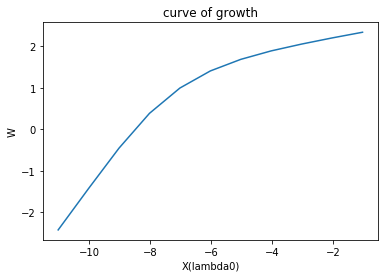

In [79]:
plt.plot(np.log10(k_c[:-1]), np.log10(LWs[:-1]))

plt.title('curve of growth')
plt.xlabel('X(lambda0)')
plt.ylabel('W')
# LWs

## 6. 미시난류 변화에 따른 변화

In [80]:
#number of c
n_c = np.logspace(0,11,12)
n_c

array([1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07,
       1.e+08, 1.e+09, 1.e+10, 1.e+11])

In [81]:
wave_c = np.arange(5995, 6030)

def find_gc(vel):
    intensity1 = []
    intensity2 = []
    
    for c in n_c:
        print(c)
        c_od = cal_tau(wave, 1, c, vel)
        c_od_c = cal_tau(wave,0, c, vel)
    
        intens = []
        intens_c = []
    
        for i in wave_c:
            planks = []
            ods = []
        
            planks_c = []
            ods_c = []
            for j in range(0, 64):
                planks.append(plank_func(i, j))
                ods.append(c_od[j][i])
            
                planks_c.append(plank_func(i,j))
                ods_c.append(c_od_c[j][i])
    
            ods2 = [np.exp(-x) for x in ods]
            integrand = [x*y for x,y in zip(planks,ods2)]
        
            ods2_c = [np.exp(-x) for x in ods_c]
            integrand_c = [x*y for x,y in zip(planks_c,ods2_c)]
        
            inte = integrate.simps(integrand, ods)
            inte_c = integrate.simps(integrand_c, ods_c)
            intens.append(inte)
            intens_c.append(inte_c)
        
        intensity1.append(intens)
        intensity2.append(intens_c)

    LWs = []
    for i in range(len(n_c)):
        F_l = intensity1[i]
        F_c = intensity2[i]
    
        R = [np.abs((x - y)/x) for x,y in zip(F_l, F_c)]
    
        integral = integrate.simps(R, wave_c)
        LWs.append(integral)
    
    return LWs


In [82]:
LW_15000 = find_gc(15000)
LW_150000 = find_gc(150000)
LW_1500000 = find_gc(1500000)

1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
100000000.0
1000000000.0
10000000000.0
100000000000.0
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
100000000.0
1000000000.0
10000000000.0
100000000000.0
1.0
10.0
100.0
1000.0
10000.0
100000.0
1000000.0
10000000.0
100000000.0
1000000000.0
10000000000.0
100000000000.0


In [83]:
def find_x(vel):
    k_c = []

    for c in n_c:

        k_voigt1 = voigt_profile(45, wave_c,  6013.17, 1, 1, 1,0, 150000, c )
        k_voigt2 = voigt_profile(45, wave_c,  6013.21, 1, 1, 1,1, 150000, c )
        k_voigt3 = voigt_profile(45, wave_c, 6014.83, 1, 1, 1,2, 150000, c )

        k_voigt = k_voigt1 + k_voigt2 + k_voigt3
    
        k_c.append(k_voigt[17])
    
    return k_c

In [84]:
x15000 = find_x(15000)
x150000 = find_x(150000)
x1500000 = find_x(1500000)

#### 5 에서의 계산을 미시난류값만 바꾸어 반복하면, 미시난류가 클수록 flat part에 도달하는 시기가 늦어진다(line center에서의 포화가 더 큰 W값에서 일어난다.). 이 이유는 

Text(0, 0.5, 'W')

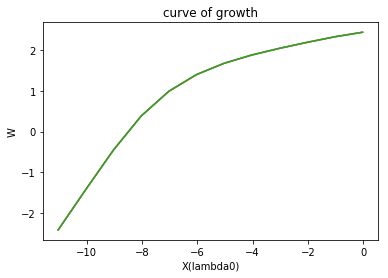

In [85]:
plt.plot(np.log10(x15000), np.log10(LW_15000))

plt.plot(np.log10(x150000), np.log10(LW_150000))

plt.plot(np.log10(x1500000), np.log10(LW_1500000))

plt.title('curve of growth')
plt.xlabel('X(lambda0)')
plt.ylabel('W')

In [86]:
wave = np.arange(1,15999)

def find_spectrum(vel):
    od = cal_tau(wave, 1, 1, vel)
    od_c = cal_tau(wave,0, 0, vel)
    
    intensities1 = []
    for i in wave:
        planks = []
        ods = []
        for j in range(0, 64):
            planks.append(plank_func(i, j))
            ods.append(optical_depth[j][i])
    
        ods2 = [np.exp(-x) for x in ods]
        integrand1 = [x*y for x,y in zip(planks,ods2)]
    
        intensity1 = integrate.simps(integrand1, ods)
        intensities1.append(intensity1)
    return intensities

In [87]:
sp_1500 = find_spectrum(1500000)
sp_150000 = find_spectrum(15000000)
sp_15000000 = find_spectrum(15000000000)

#### 미시 난류의 값이 커질수록 sigma 값의 증가로 스펙트럼의 흡수선이 더욱 broadening 해져야 한다..

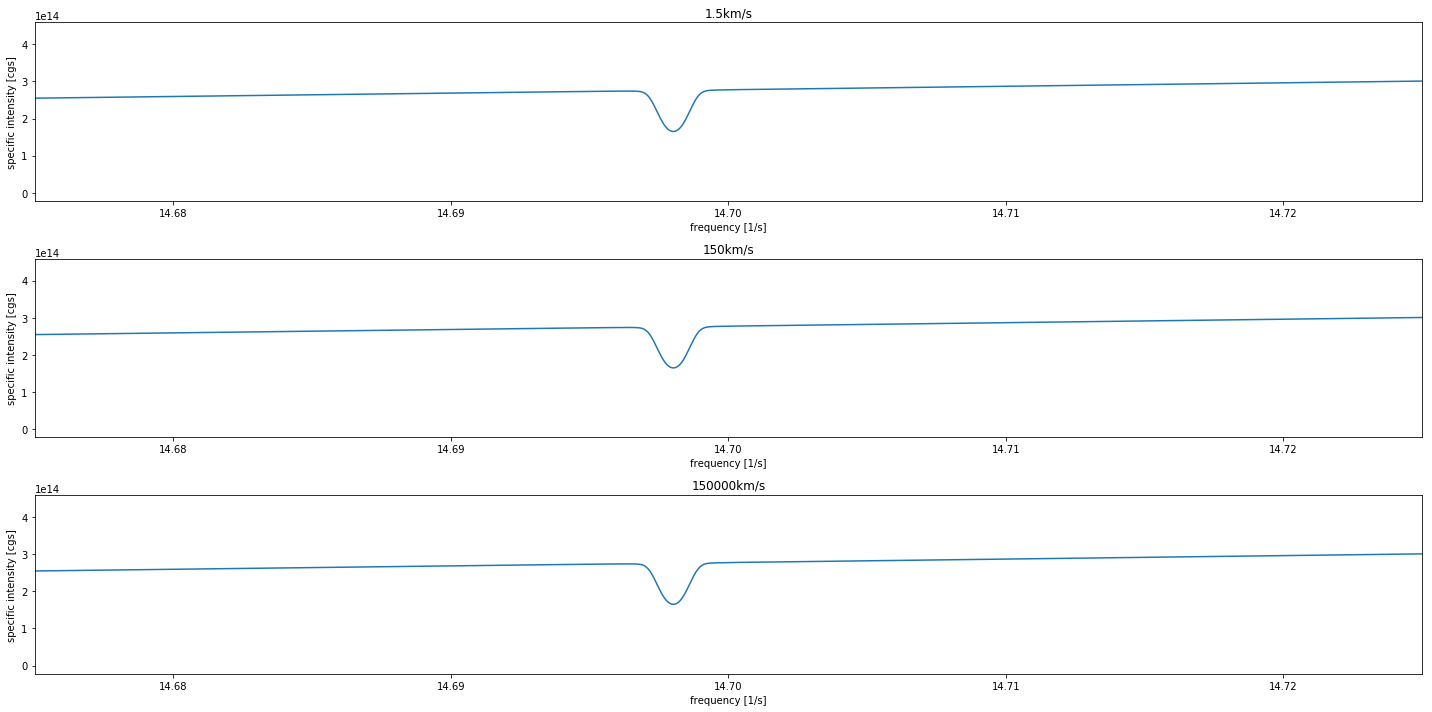

In [96]:
fig, ax = plt.subplots(3, figsize = (20,10))

wave = np.arange(1, 15999)

ax[0].plot(np.log10(c/wave/1.e-8), sp_1500)
ax[1].plot(np.log10(c/wave/1.e-8), sp_150000)
ax[2].plot(np.log10(c/wave/1.e-8), sp_15000000)

for i in range(3):
    ax[i].set_xlim(14.675, 14.725)
    ax[i].set_xlabel('frequency [1/s]')
    ax[i].set_ylabel('specific intensity [cgs]')
ax[0].set_title('1.5km/s')
ax[1].set_title('150km/s')
ax[2].set_title('150000km/s')

plt.tight_layout()